In [77]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import leidenalg 
import igraph as ig
import networkx as nx
from collections import defaultdict
sys.path.append('../')
from src.util_data import loadNodeAttr
from src.util import getInletIds, getOutletIds
sys.path.append('../src/data_cleaning/snair')
from clean_am import *
import json

In [78]:
def get_pos(txt_file, small = False):
    if small:
        coordinates = np.loadtxt(txt_file)[:,:2]
        return coordinates
    LS = read_am(txt_file)
    LS_edge_prop = edgeProps(LS, small = small)
#     assert(len(LS_edge_prop)==len(LS[2]))
    LS_clean = cleanEdgelist(LS, LS_edge_prop)
    coordinates = {}
    for edge, attr in LS_clean.items():
        coordinates[edge[0]] = np.asarray(attr['srcCords'])
        coordinates[edge[1]] = np.asarray(attr['dstCords'])
#     return dict(zip(range(coordinates.shape[0]), coordinates))
    return coordinates

In [99]:
G_LS174T = ig.Graph.Read_Ncol('../data/Edgelist_v2/LS174T_clean_EdgesList.txt', names= True, weights="if_present", directed=False)
G_SW1222 = ig.Graph.Read_Ncol('../data/Edgelist_v2/SW1222_clean_EdgesList.txt', names= True, weights="if_present", directed=True)
G_Mes = ig.Graph.Read_Ncol('../data/Edgelist_v2/Mesentery_clean_EdgeList.txt', names= True, weights="if_present", directed=True)

In [5]:
part_LS = leidenalg.find_partition(G_LS174T, leidenalg.RBConfigurationVertexPartition)
part_SW = leidenalg.find_partition(G_SW1222, leidenalg.RBConfigurationVertexPartition)
part_Mes = leidenalg.find_partition(G_Mes, leidenalg.RBConfigurationVertexPartition)

In [100]:
part_LS = leidenalg.find_partition(G_LS174T, leidenalg.ModularityVertexPartition)
part_SW = leidenalg.find_partition(G_SW1222, leidenalg.ModularityVertexPartition)
part_Mes = leidenalg.find_partition(G_Mes, leidenalg.ModularityVertexPartition)

In [81]:
G_Mes = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/Mesentery_clean_EdgeList.txt", 0, 1, ' ')
nidx2clust_m = {}
total = set()
print G_Mes.GetNodes()
for i,x in enumerate(part_Mes):
    for y in x:
#         print y
        if G_Mes.IsNode(y):
            total.add(y)
            nidx2clust_m[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_m.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))
clusters_m = []
for i in range(388):
    if i in nidx2clust_m:
        clusters_m.append(nidx2clust_m[i]+1)
    else:
        clusters_m.append(0)
np.savetxt('M_communities.txt',np.asarray(clusters_m), delimiter='\n')

388
Number of communities = 15, largest community = 41


In [ ]:
G_M = nx.read_edgelist("../data/Edgelist_v2/Mesentery_clean_EdgeList.txt", nodetype=int)
# LS174T_pos = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
# print(LS174T_pos)
m_coords = get_pos('m_coordinates.txt', small = True)
nx.draw(G_M, node_color=np.asarray(nidx2clust_m.values()), pos = m_coords, node_size=50, cmap=plt.cm.Paired)
plt.savefig('../figs/Mes_clustering.pdf')

Save communities in dictionary for LS174T

In [101]:
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1, '\t')
nidx2clust_LS = {}
total = set()
for i,x in enumerate(part_LS):
    for y in x:
        if G_LS174T.IsNode(y):
            total.add(y)
            nidx2clust_LS[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_LS.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 159, largest community = 450


In [102]:
community_LS = defaultdict(set)
for node, community in nidx2clust_LS.items():
    community_LS[community].add(node)
community_LS = dict(community_LS)

In [103]:
G_LS=nx.Graph()
G_LS.add_nodes_from(community_LS.keys())
for community, nodes in community_LS.items():
    nbrs = set()
    for node in nodes:
        node_nbr = [nbrs.add(nbr) for nbr in G_LS174T.GetNI(node).GetOutEdges()]
    for community2, nodes2 in community_LS.items():
        if community == community2:
            continue
        if nodes2 &nbrs:
            G_LS.add_edge(community, community2)
community_sizes = [len(val) for val in community_LS.values()]
community_colors = np.arange(len(community_sizes))
community_colors[community_sizes==1] = 1000
community_position = []
coordinates = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
community_coordinates = {}
for community, nodes in community_LS.items():
    sum_coord = np.asarray([0,0,0]).astype(np.float64)
    for node in nodes:
        sum_coord += coordinates[node]
    community_coordinates[community] = sum_coord[:2]/float(len(nodes))
# print np.argsort(community_sizes)
print np.argmax(np.asarray(community_sizes)==22)

63


Clustering with 10 elements and 4 clusters
[0] 5, 6, 7
[1] 0, 1, 2
[2] 3, 4
[3] 8, 9


TypeError: 'Graph' object is not iterable

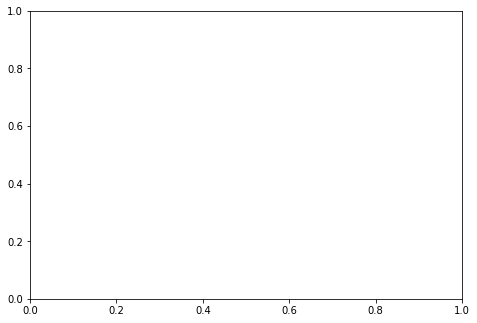

In [110]:
# LS = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int)
# subgraph_LS = LS.subgraph(list(community_LS[0]))
# print(len(subgraph_LS.edges()))
# total_degree= 0
# for node in subgraph_LS.nodes():
#     total_degree+=G_LS174T.GetNI(node).GetDeg()
# print(total_degree)
# nx.draw(subgraph_LS, cmap = plt.cm.Paired, width = 0.5, node_size=10)

test = ig.Graph()
test.add_vertices(10)
test.add_edges([(0,1),(1,2), (0,3),  (3,4), (0,5), (5,6), (6,7), (5,8), (8,9)])
part_test = leidenalg.find_partition(test, leidenalg.ModularityVertexPartition)
print part_test

# nx.draw(test, cmap = plt.cm.Paired, width = 0.5, node_size=10)


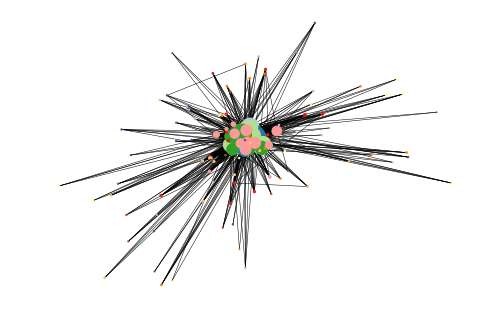

In [68]:
nx.draw(G_LS, node_color=community_colors, pos = community_coordinates, node_size=community_sizes, cmap=plt.cm.Paired, width = 0.5)

In [8]:
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/SW1222_clean_EdgesList.txt", 0, 1, '\t')
nidx2clust_SW = {}
total = set()
for i,x in enumerate(part_SW):
    for y in x:
        if G_SW1222.IsNode(y):
            total.add(y)
            nidx2clust_SW[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_SW.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 999, largest community = 866


In [9]:
community_SW = defaultdict(set)
for node, community in nidx2clust_SW.items():
    community_SW[node].add(i)
community_SW = dict(community_SW)

In [ ]:
G_SW=nx.Graph()
G_SW.add_nodes_from(community_SW.keys())
for community, nodes in community_SW.items():
    nbrs = set()
    for node in nodes:
        node_nbr = [nbrs.add(nbr) for nbr in G_SW1222.GetNI(node).GetOutEdges()]
    for community2, nodes2 in community_SW.items():
        if community == community2:
            continue
        if nodes2 &nbrs:
            G_SW.add_edge(community, community2)
community_sizes = [len(val) for val in community_LS.values()]
community_colors = np.arange(len(community_sizes))
community_colors[community_sizes==1] = 1000
community_position = []
coordinates = get_pos('../data/og_files/SW1222_spatialGraph_RIN.txt')
community_coordinates = {}
for community, nodes in community_SW.items():
    sum_coord = np.asarray([0,0,0]).astype(np.float64)
    for node in nodes:
        sum_coord += coordinates[node]
    community_coordinates[community] = sum_coord[:2]/float(len(nodes))
print community_coordinates[0]

In [ ]:
G_LS174T_nx = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int)
# LS174T_pos = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
# print(LS174T_pos)
nx.draw(G_LS174T_nx, node_color=np.asarray(nidx2clust_LS.values()), pos = LS174T_pos, node_size=10, cmap=plt.cm.Paired)
plt.savefig('LS_clustering.pdf')

In [10]:
clusters_LS = []
for i in range(18093):
    if i in nidx2clust_LS:
        clusters_LS.append(nidx2clust_LS[i]+1)
    else:
        clusters_LS.append(0)
clusters_SW = []
for i in range(72084):
    if i in nidx2clust_SW:
        clusters_SW.append(nidx2clust_SW[i]+1)
    else:
        clusters_SW.append(0)
np.savetxt('SW_communities.txt',np.asarray(clusters_SW), delimiter='\n')
np.savetxt('LS_communities.txt',np.asarray(clusters_LS), delimiter='\n')

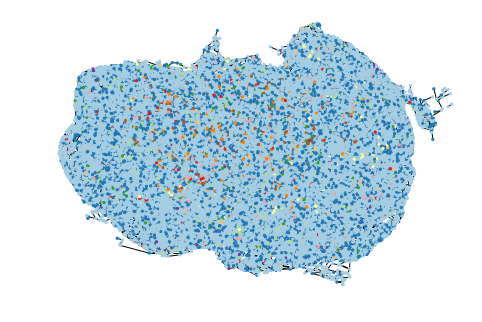

In [26]:
G_SW1222_nx = nx.read_edgelist("../data/Edgelist_v2/SW1222_clean_EdgesList.txt", nodetype=int)
SW1222_pos = get_pos('../data/og_files/SW1222_coordinates.txt')
# print(LS174T_pos)
nx.draw(G_SW1222_nx, node_color=np.asarray(nidx2clust_SW.values()), pos = SW1222_pos, node_size=5, cmap=plt.cm.Paired)
plt.savefig('SW_clustering.pdf')

In [9]:
np.savetxt('LS_communities.txt', nidx2clust_LS, delimiter = ' ')
np.savetxt('SW_communities.txt', nidx2clust_SW, delimiter = ' ')

In [12]:
radii_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt')
radii_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt')
pressure_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'pressure')
pressure_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'pressure')
flow_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'flow')
flow_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'flow')

In [8]:
#Check flow consistency
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/LS174T_clean_EdgesList.txt", 0, 1, '\t')
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/SW1222_clean_EdgesList.txt", 0, 1, '\t')
inlets_LS = getInletIds(G_LS174T)
inlets_SW = getInletIds(G_SW1222)
outlets_LS = getOutletIds(G_LS174T)
outlets_SW = getOutletIds(G_SW1222)
inlet_flow_LS = [flow_LS[inlet] for inlet in inlets_LS]
outlet_flow_LS = [flow_LS[outlet] for outlet in outlets_LS]
inlet_flow_SW = [flow_SW[inlet] for inlet in inlets_SW]
outlet_flow_SW = [flow_SW[outlet] for outlet in outlets_SW]

print np.sum(inlet_flow_LS)
print np.sum(outlet_flow_LS)
print np.sum(inlet_flow_SW)
print np.sum(outlet_flow_SW)

39489.88763162267
40710.2160796772
842943.4201301008
855436.2396368664


In [13]:
community_radii_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_radii_LS[cluster].append(radii_LS[node])

In [14]:
community_flow_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_flow_LS[cluster].append(flow_LS[node])

In [27]:
community_pressure_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_pressure_LS[cluster].append(pressure_LS[node])

In [16]:
community_radii_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_radii_SW[cluster].append(radii_SW[node])

In [17]:
community_flow_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_flow_SW[cluster].append(flow_SW[node])

In [18]:
community_pressure_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_pressure_SW[cluster].append(pressure_SW[node])

[]

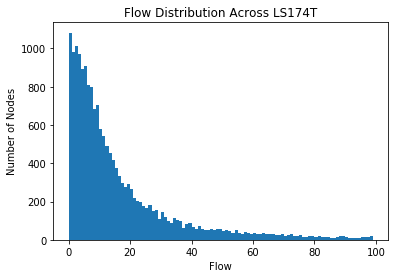

In [19]:
plt.hist(flow_LS.values(), bins = np.arange(0,100,1))
plt.xlabel('Flow')
plt.ylabel('Number of Nodes')
plt.title('Flow Distribution Across LS174T')
plt.plot()

[]

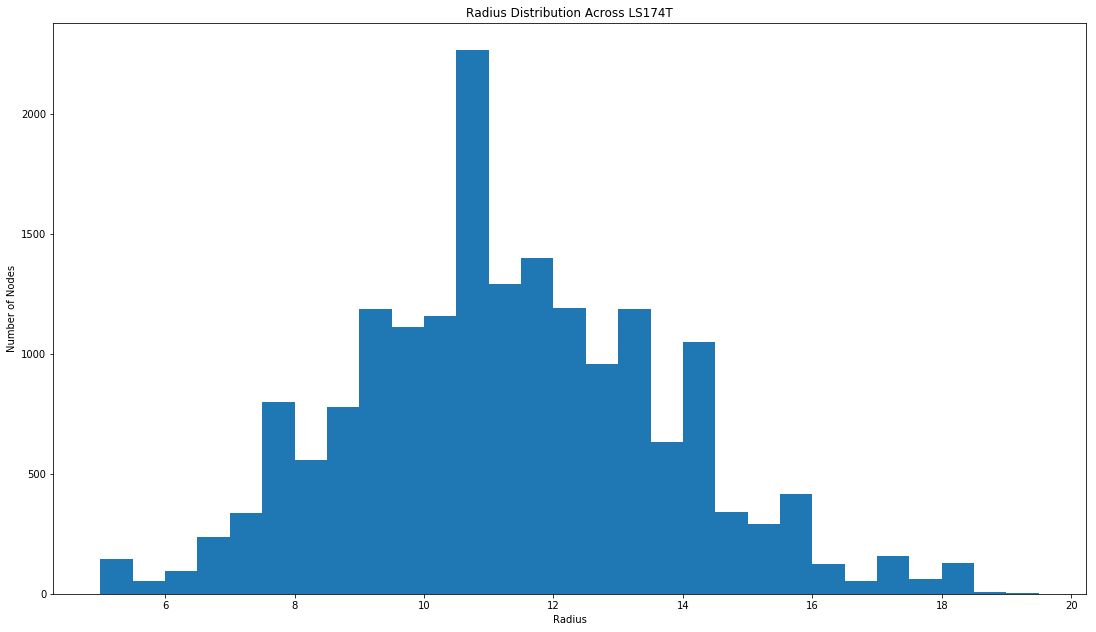

In [20]:
plt.hist(radii_LS.values(), bins = np.arange(5,20,0.5))
plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Radius')
plt.ylabel('Number of Nodes')
plt.title('Radius Distribution Across LS174T')
plt.plot()

[]

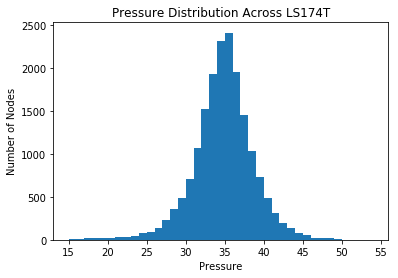

In [21]:
plt.hist(pressure_LS.values(), bins = np.arange(15,55,1))
plt.xlabel('Pressure')
plt.ylabel('Number of Nodes')
plt.title('Pressure Distribution Across LS174T')
plt.plot()

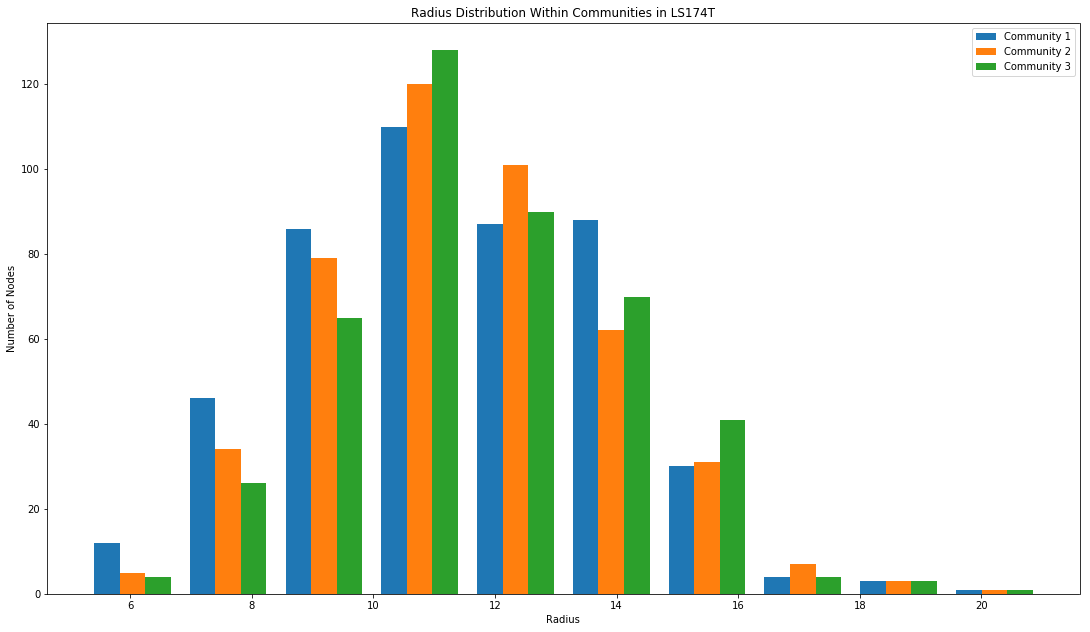

In [22]:
plt.hist(community_radii_LS.values()[:3], label=['Community 1', 'Community 2', 'Community 3'])
plt.xlabel('Radius')
plt.ylabel('Number of Nodes')
plt.title('Radius Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)

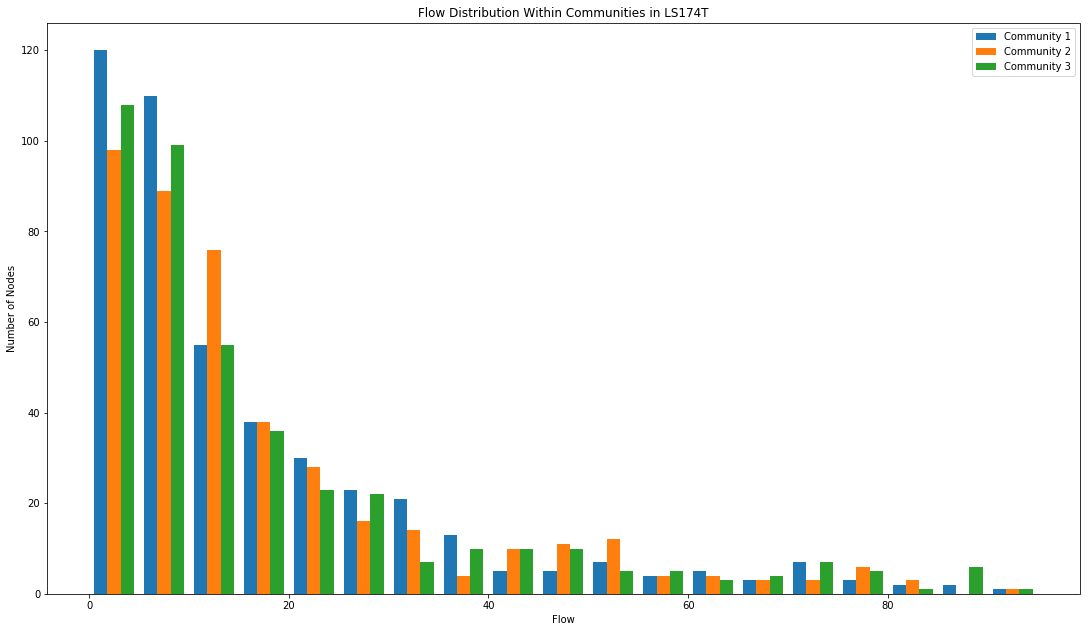

In [33]:
plt.hist(community_flow_LS.values()[:3], bins = np.arange(0,100,5), label=['Community 1', 'Community 2', 'Community 3'])
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Flow')
plt.ylabel('Number of Nodes')
plt.title('Flow Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)

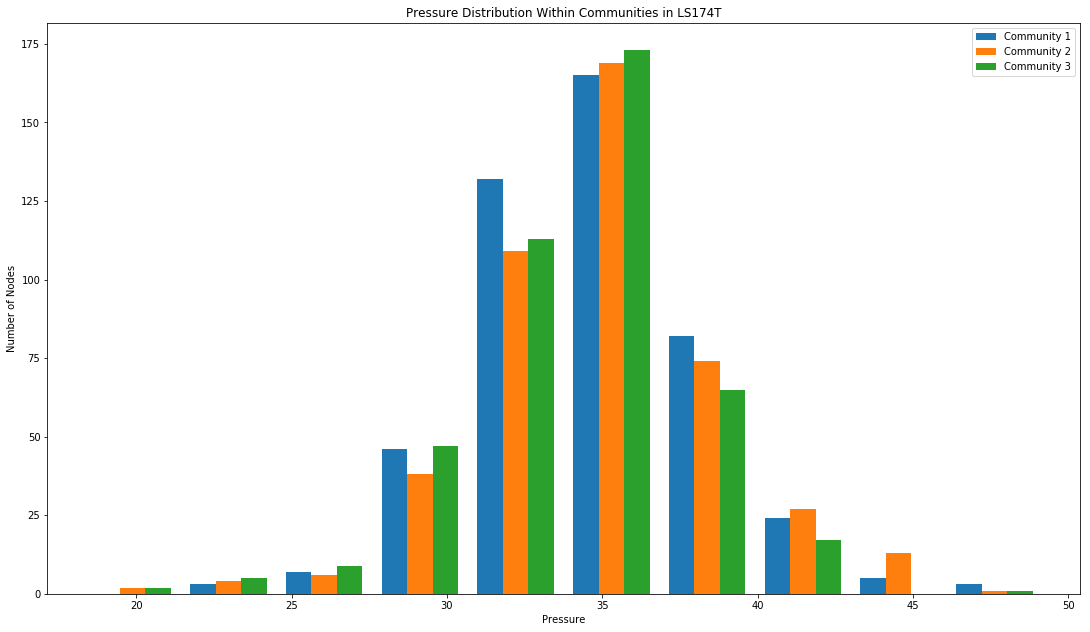

In [29]:
plt.hist(community_pressure_LS.values()[:3], label=['Community 1', 'Community 2', 'Community 3'])
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Pressure')
plt.ylabel('Number of Nodes')
plt.title('Pressure Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)